# Face Generation using Generative Adversarial Networks (GAN)

### 1. Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance

### 2. Setting Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 3. Dataset & Transform

In [3]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_names = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_names[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 4. Loading Images

In [4]:
dataset = FaceDataset(root_dir='./augmented_images', transform=transform)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Loaded {len(dataset)} images from ./augmented_images")

Loaded 5000 images from ./augmented_images


### 5. Visualizing Sample Images from Dataset

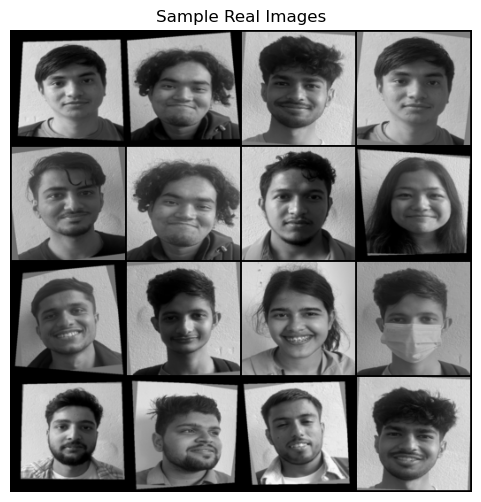

In [5]:
def show_sample_images(dataloader, n=16):
    images = next(iter(dataloader))[:n]
    images = images * 0.5 + 0.5  # Denormalize [-1,1] → [0,1]
    grid = torchvision.utils.make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.title("Sample Real Images")
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

show_sample_images(dataloader)

### 6. Defining the DCGAN Discriminator for 128x128 grayscale images

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),      # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),           # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),          # 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),          # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),            # 5x5 output
            # remove Sigmoid here, do it in forward
        )

    def forward(self, x):
        out = self.net(x)              # (batch_size, 1, 5, 5)
        out = out.view(out.size(0), -1)  # (batch_size, 25)
        out = torch.mean(out, dim=1)     # (batch_size,)
        out = torch.sigmoid(out)
        return out


### 7. Defining the DCGAN Generator for 128x128 grayscale images

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0),   # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),          # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),          # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),           # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 4, 0),      # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

### 8. Instantiating models, optimizers, and loss function

In [8]:
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 2e-4
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

num_epochs = 100
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

### 9. Helper Function to Visualize Generated Images during training

In [9]:
def show_generated_images(images, epoch=None):
    images = images.cpu()
    images = (images + 1) / 2  # [-1,1] → [0,1]
    grid = torchvision.utils.make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if epoch is not None:
        plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

### 10. Training Loop

Epoch 1/100 | G_loss: 5.3546, D_loss: 0.2688, G_acc: 0.0042, D_acc: 0.4923
Epoch 2/100 | G_loss: 3.7228, D_loss: 0.5467, G_acc: 0.0292, D_acc: 0.4929
Epoch 3/100 | G_loss: 3.5750, D_loss: 0.5983, G_acc: 0.0333, D_acc: 0.5050
Epoch 4/100 | G_loss: 2.8640, D_loss: 0.6926, G_acc: 0.0479, D_acc: 0.4987
Epoch 5/100 | G_loss: 3.1036, D_loss: 0.6241, G_acc: 0.0351, D_acc: 0.4983
Epoch 6/100 | G_loss: 3.2276, D_loss: 0.5801, G_acc: 0.0304, D_acc: 0.5021
Epoch 7/100 | G_loss: 3.2242, D_loss: 0.5395, G_acc: 0.0278, D_acc: 0.4973
Epoch 8/100 | G_loss: 3.3280, D_loss: 0.4629, G_acc: 0.0122, D_acc: 0.4985
Epoch 9/100 | G_loss: 3.4120, D_loss: 0.4545, G_acc: 0.0280, D_acc: 0.5038
Epoch 10/100 | G_loss: 3.3224, D_loss: 0.4748, G_acc: 0.0286, D_acc: 0.4982


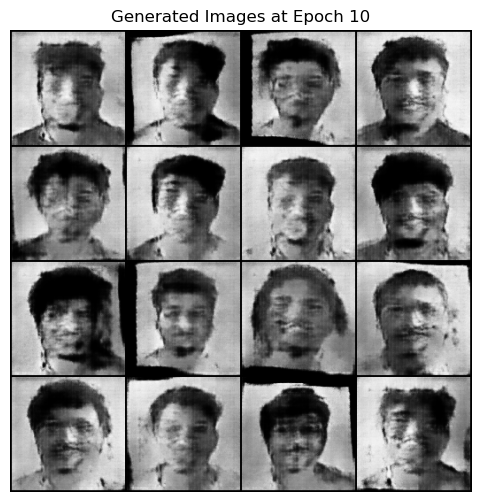

FID at epoch 10: 307.98
Epoch 11/100 | G_loss: 3.4189, D_loss: 0.3977, G_acc: 0.0210, D_acc: 0.5015
Epoch 12/100 | G_loss: 3.3584, D_loss: 0.4642, G_acc: 0.0329, D_acc: 0.5022
Epoch 13/100 | G_loss: 3.3832, D_loss: 0.4105, G_acc: 0.0258, D_acc: 0.4986
Epoch 14/100 | G_loss: 3.4911, D_loss: 0.3668, G_acc: 0.0216, D_acc: 0.4977
Epoch 15/100 | G_loss: 3.5397, D_loss: 0.4391, G_acc: 0.0262, D_acc: 0.4971
Epoch 16/100 | G_loss: 3.5853, D_loss: 0.3881, G_acc: 0.0200, D_acc: 0.4987
Epoch 17/100 | G_loss: 3.6667, D_loss: 0.3510, G_acc: 0.0174, D_acc: 0.5009
Epoch 18/100 | G_loss: 3.8846, D_loss: 0.3275, G_acc: 0.0174, D_acc: 0.4983
Epoch 19/100 | G_loss: 4.0094, D_loss: 0.3104, G_acc: 0.0240, D_acc: 0.5003
Epoch 20/100 | G_loss: 4.0781, D_loss: 0.3054, G_acc: 0.0210, D_acc: 0.5019


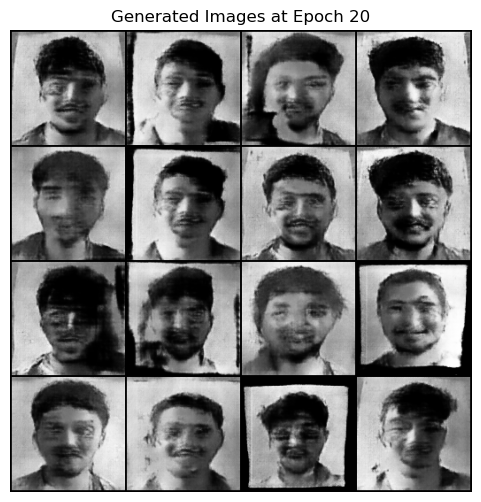

FID at epoch 20: 205.54
Epoch 21/100 | G_loss: 4.0052, D_loss: 0.3154, G_acc: 0.0202, D_acc: 0.4998
Epoch 22/100 | G_loss: 3.9583, D_loss: 0.3553, G_acc: 0.0266, D_acc: 0.4986
Epoch 23/100 | G_loss: 4.0833, D_loss: 0.2443, G_acc: 0.0118, D_acc: 0.4998
Epoch 24/100 | G_loss: 4.1017, D_loss: 0.3105, G_acc: 0.0256, D_acc: 0.4966
Epoch 25/100 | G_loss: 4.1878, D_loss: 0.3238, G_acc: 0.0210, D_acc: 0.5009
Epoch 26/100 | G_loss: 4.1159, D_loss: 0.1951, G_acc: 0.0038, D_acc: 0.5006
Epoch 27/100 | G_loss: 4.2285, D_loss: 0.2664, G_acc: 0.0132, D_acc: 0.4999
Epoch 28/100 | G_loss: 4.2987, D_loss: 0.2859, G_acc: 0.0196, D_acc: 0.4988
Epoch 29/100 | G_loss: 4.2036, D_loss: 0.2147, G_acc: 0.0108, D_acc: 0.4990
Epoch 30/100 | G_loss: 4.4108, D_loss: 0.2263, G_acc: 0.0148, D_acc: 0.5012


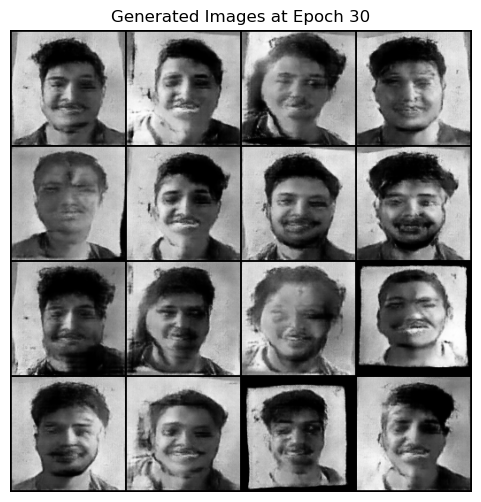

FID at epoch 30: 203.89
Epoch 31/100 | G_loss: 4.4654, D_loss: 0.2555, G_acc: 0.0166, D_acc: 0.5014
Epoch 32/100 | G_loss: 4.4507, D_loss: 0.1813, G_acc: 0.0100, D_acc: 0.5003
Epoch 33/100 | G_loss: 4.6999, D_loss: 0.1890, G_acc: 0.0146, D_acc: 0.4998
Epoch 34/100 | G_loss: 4.7644, D_loss: 0.1426, G_acc: 0.0044, D_acc: 0.4989
Epoch 35/100 | G_loss: 4.5665, D_loss: 0.2475, G_acc: 0.0154, D_acc: 0.4994
Epoch 36/100 | G_loss: 4.6832, D_loss: 0.1451, G_acc: 0.0044, D_acc: 0.4995
Epoch 37/100 | G_loss: 4.7327, D_loss: 0.2187, G_acc: 0.0180, D_acc: 0.5007
Epoch 38/100 | G_loss: 4.7929, D_loss: 0.2098, G_acc: 0.0198, D_acc: 0.4977
Epoch 39/100 | G_loss: 4.8102, D_loss: 0.1516, G_acc: 0.0076, D_acc: 0.4991
Epoch 40/100 | G_loss: 4.7898, D_loss: 0.2145, G_acc: 0.0092, D_acc: 0.5004


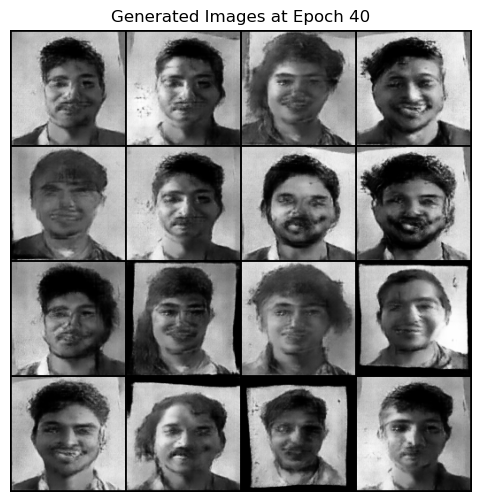

FID at epoch 40: 178.57
Epoch 41/100 | G_loss: 4.8921, D_loss: 0.2635, G_acc: 0.0222, D_acc: 0.4987
Epoch 42/100 | G_loss: 4.7199, D_loss: 0.1117, G_acc: 0.0032, D_acc: 0.4995
Epoch 43/100 | G_loss: 4.8029, D_loss: 0.1697, G_acc: 0.0108, D_acc: 0.4999
Epoch 44/100 | G_loss: 4.9183, D_loss: 0.1418, G_acc: 0.0072, D_acc: 0.4996
Epoch 45/100 | G_loss: 4.9606, D_loss: 0.2406, G_acc: 0.0188, D_acc: 0.4989
Epoch 46/100 | G_loss: 4.7825, D_loss: 0.1859, G_acc: 0.0116, D_acc: 0.4989
Epoch 47/100 | G_loss: 4.8165, D_loss: 0.0654, G_acc: 0.0006, D_acc: 0.4996
Epoch 48/100 | G_loss: 5.0249, D_loss: 0.2418, G_acc: 0.0162, D_acc: 0.4988
Epoch 49/100 | G_loss: 5.0731, D_loss: 0.1104, G_acc: 0.0046, D_acc: 0.5000
Epoch 50/100 | G_loss: 5.2431, D_loss: 0.2113, G_acc: 0.0108, D_acc: 0.4992


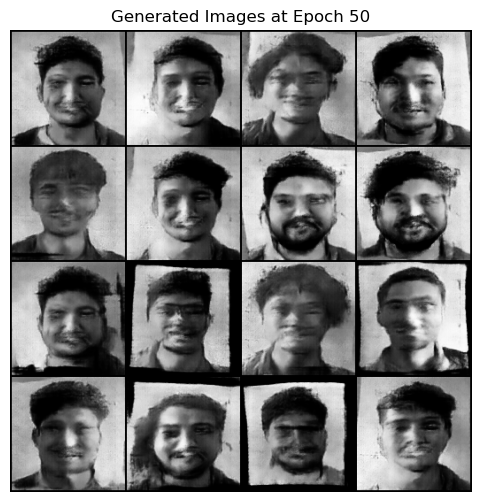

FID at epoch 50: 176.12
Epoch 51/100 | G_loss: 4.9890, D_loss: 0.0795, G_acc: 0.0014, D_acc: 0.4997
Epoch 52/100 | G_loss: 5.3387, D_loss: 0.0963, G_acc: 0.0056, D_acc: 0.4991
Epoch 53/100 | G_loss: 5.0337, D_loss: 0.2689, G_acc: 0.0214, D_acc: 0.4992
Epoch 54/100 | G_loss: 4.9582, D_loss: 0.0558, G_acc: 0.0010, D_acc: 0.4991
Epoch 55/100 | G_loss: 5.3956, D_loss: 0.1800, G_acc: 0.0146, D_acc: 0.4996
Epoch 56/100 | G_loss: 5.2433, D_loss: 0.0701, G_acc: 0.0004, D_acc: 0.4993
Epoch 57/100 | G_loss: 5.4697, D_loss: 0.1834, G_acc: 0.0138, D_acc: 0.4991
Epoch 58/100 | G_loss: 5.1883, D_loss: 0.0616, G_acc: 0.0010, D_acc: 0.4998
Epoch 59/100 | G_loss: 5.2616, D_loss: 0.2188, G_acc: 0.0142, D_acc: 0.4984
Epoch 60/100 | G_loss: 5.3710, D_loss: 0.1705, G_acc: 0.0152, D_acc: 0.4989


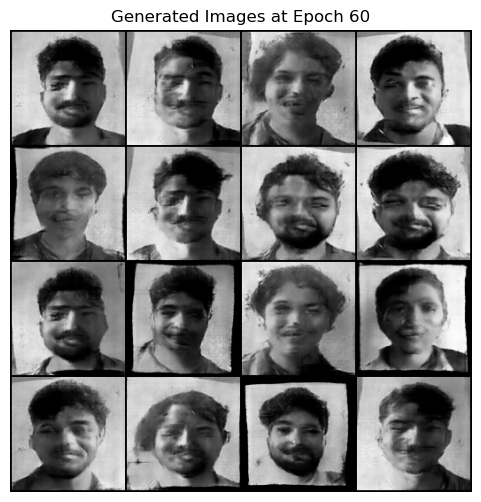

FID at epoch 60: 206.65
Epoch 61/100 | G_loss: 5.1794, D_loss: 0.0620, G_acc: 0.0000, D_acc: 0.5000
Epoch 62/100 | G_loss: 5.5977, D_loss: 0.0510, G_acc: 0.0012, D_acc: 0.5001
Epoch 63/100 | G_loss: 5.2987, D_loss: 0.2140, G_acc: 0.0142, D_acc: 0.4988
Epoch 64/100 | G_loss: 5.5414, D_loss: 0.1610, G_acc: 0.0090, D_acc: 0.5003
Epoch 65/100 | G_loss: 5.2809, D_loss: 0.0794, G_acc: 0.0046, D_acc: 0.4997
Epoch 66/100 | G_loss: 5.4062, D_loss: 0.1602, G_acc: 0.0114, D_acc: 0.5007
Epoch 67/100 | G_loss: 5.3291, D_loss: 0.0463, G_acc: 0.0006, D_acc: 0.4993
Epoch 68/100 | G_loss: 5.4578, D_loss: 0.2386, G_acc: 0.0172, D_acc: 0.4997
Epoch 69/100 | G_loss: 5.1981, D_loss: 0.0449, G_acc: 0.0002, D_acc: 0.4996
Epoch 70/100 | G_loss: 5.3409, D_loss: 0.1586, G_acc: 0.0068, D_acc: 0.4991


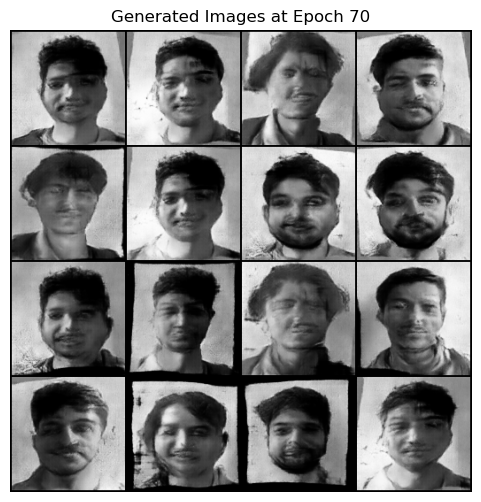

FID at epoch 70: 164.98
Epoch 71/100 | G_loss: 5.5358, D_loss: 0.1427, G_acc: 0.0086, D_acc: 0.5000
Epoch 72/100 | G_loss: 5.4392, D_loss: 0.0459, G_acc: 0.0006, D_acc: 0.5000
Epoch 73/100 | G_loss: 5.4158, D_loss: 0.2736, G_acc: 0.0200, D_acc: 0.4994
Epoch 74/100 | G_loss: 5.3824, D_loss: 0.1335, G_acc: 0.0068, D_acc: 0.4995
Epoch 75/100 | G_loss: 5.2987, D_loss: 0.0475, G_acc: 0.0000, D_acc: 0.4997
Epoch 76/100 | G_loss: 5.2525, D_loss: 0.1204, G_acc: 0.0066, D_acc: 0.4990
Epoch 77/100 | G_loss: 5.6854, D_loss: 0.0342, G_acc: 0.0004, D_acc: 0.4997
Epoch 78/100 | G_loss: 5.9117, D_loss: 0.1527, G_acc: 0.0088, D_acc: 0.4996
Epoch 79/100 | G_loss: 5.5801, D_loss: 0.0400, G_acc: 0.0000, D_acc: 0.4996
Epoch 80/100 | G_loss: 5.6027, D_loss: 0.1933, G_acc: 0.0108, D_acc: 0.4993


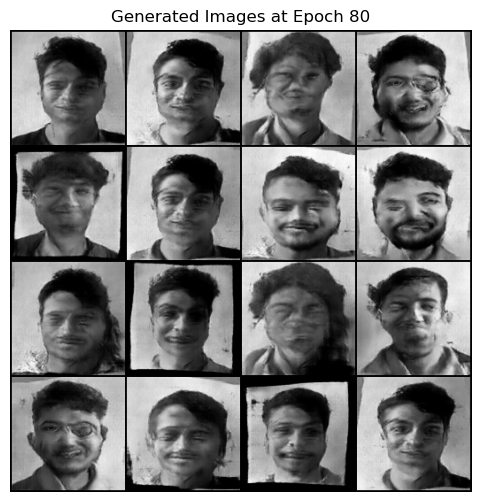

FID at epoch 80: 183.82
Epoch 81/100 | G_loss: 5.5075, D_loss: 0.0355, G_acc: 0.0002, D_acc: 0.5002
Epoch 82/100 | G_loss: 5.5705, D_loss: 0.1808, G_acc: 0.0086, D_acc: 0.5006
Epoch 83/100 | G_loss: 5.6302, D_loss: 0.0551, G_acc: 0.0020, D_acc: 0.4993
Epoch 84/100 | G_loss: 5.8359, D_loss: 0.1186, G_acc: 0.0066, D_acc: 0.4995
Epoch 85/100 | G_loss: 5.6882, D_loss: 0.0393, G_acc: 0.0004, D_acc: 0.4999
Epoch 86/100 | G_loss: 5.8615, D_loss: 0.0234, G_acc: 0.0000, D_acc: 0.4997
Epoch 87/100 | G_loss: 6.5818, D_loss: 0.1868, G_acc: 0.0086, D_acc: 0.5001
Epoch 88/100 | G_loss: 5.7624, D_loss: 0.0302, G_acc: 0.0002, D_acc: 0.4995
Epoch 89/100 | G_loss: 6.1341, D_loss: 0.1388, G_acc: 0.0076, D_acc: 0.4990
Epoch 90/100 | G_loss: 6.0195, D_loss: 0.1378, G_acc: 0.0062, D_acc: 0.4992


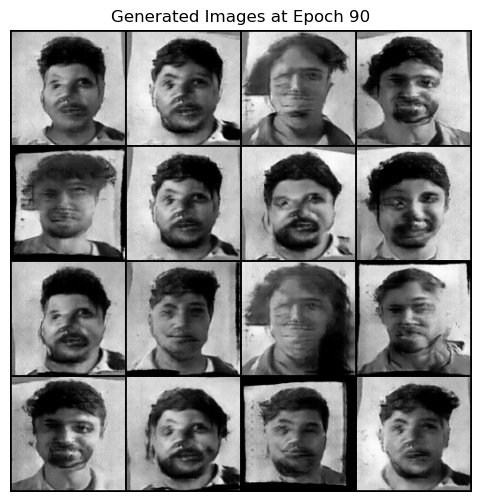

FID at epoch 90: 188.92
Epoch 91/100 | G_loss: 6.2421, D_loss: 0.0941, G_acc: 0.0050, D_acc: 0.4998
Epoch 92/100 | G_loss: 5.6709, D_loss: 0.0316, G_acc: 0.0000, D_acc: 0.4996
Epoch 93/100 | G_loss: 5.9586, D_loss: 0.1294, G_acc: 0.0110, D_acc: 0.5001
Epoch 94/100 | G_loss: 5.8677, D_loss: 0.0594, G_acc: 0.0010, D_acc: 0.4986
Epoch 95/100 | G_loss: 6.2658, D_loss: 0.0671, G_acc: 0.0038, D_acc: 0.4991
Epoch 96/100 | G_loss: 6.6297, D_loss: 0.0683, G_acc: 0.0026, D_acc: 0.4996
Epoch 97/100 | G_loss: 6.5079, D_loss: 0.0528, G_acc: 0.0026, D_acc: 0.4997
Epoch 98/100 | G_loss: 6.5576, D_loss: 0.0630, G_acc: 0.0046, D_acc: 0.4990
Epoch 99/100 | G_loss: 6.7435, D_loss: 0.0249, G_acc: 0.0006, D_acc: 0.5000
Epoch 100/100 | G_loss: 6.7511, D_loss: 0.0965, G_acc: 0.0030, D_acc: 0.4988


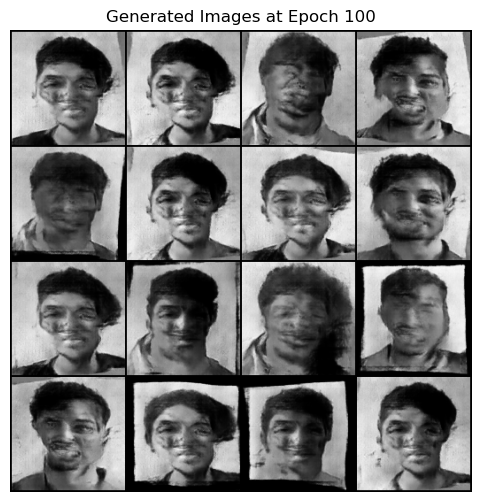

FID at epoch 100: 177.06


In [10]:
fid = FrechetInceptionDistance(feature=2048).to(device)  # Higher level features

G_losses, D_losses, G_accuracies, D_accuracies = [], [], [], []

for epoch in range(num_epochs):
    g_loss_total, d_loss_total = 0, 0
    g_acc_total, d_acc_total = 0, 0

    for real in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = generator(z)

        real_preds = discriminator(real)
        fake_preds = discriminator(fake.detach())

        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        discriminator.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Accuracy
        real_acc = ((real_preds > 0.5).float() == real_labels).float().mean().item()
        fake_acc = ((fake_preds < 0.5).float() == fake_labels).float().mean().item()
        d_acc = (real_acc + fake_acc) / 2

        # -----------------
        #  Train Generator
        # -----------------
        preds = discriminator(fake)
        g_loss = criterion(preds, real_labels)

        generator.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_acc = ((preds > 0.5).float() == real_labels).float().mean().item()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()
        g_acc_total += g_acc
        d_acc_total += d_acc

    G_losses.append(g_loss_total / len(dataloader))
    D_losses.append(d_loss_total / len(dataloader))
    G_accuracies.append(g_acc_total / len(dataloader))
    D_accuracies.append(d_acc_total / len(dataloader))

    print(f"Epoch {epoch+1}/{num_epochs} | G_loss: {G_losses[-1]:.4f}, D_loss: {D_losses[-1]:.4f}, G_acc: {G_accuracies[-1]:.4f}, D_acc: {D_accuracies[-1]:.4f}")

    # ------------------
    # Show samples & FID
    # ------------------
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            gen_imgs = generator(fixed_noise)
            show_generated_images(gen_imgs, epoch+1)

        # Compute FID
        fid.reset()
        real_batch = next(iter(dataloader)).to(device)
        fake_batch = generator(torch.randn(real_batch.size(0), latent_dim, 1, 1, device=device))

        # Prepare for FID (3 channels, uint8)
        real_batch = ((real_batch * 0.5 + 0.5) * 255).to(torch.uint8)
        fake_batch = ((fake_batch * 0.5 + 0.5) * 255).to(torch.uint8)
        if real_batch.shape[1] == 1:
            real_batch = real_batch.repeat(1, 3, 1, 1)
            fake_batch = fake_batch.repeat(1, 3, 1, 1)

        fid.update(real_batch, real=True)
        fid.update(fake_batch, real=False)
        fid_score = fid.compute().item()
        print(f"FID at epoch {epoch+1}: {fid_score:.2f}")

### 10. Saving Models

In [11]:
torch.save(generator.state_dict(), "dcgan_generator_faces.pth")
torch.save(discriminator.state_dict(), "dcgan_discriminator_faces.pth")


### 11. Plotting Curves

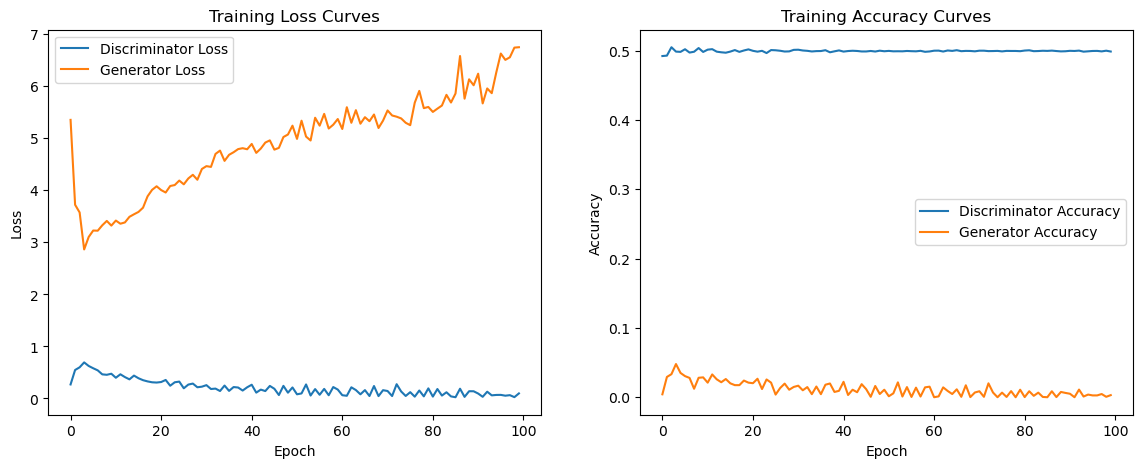

In [12]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')

plt.subplot(1,2,2)
plt.plot(D_accuracies, label='Discriminator Accuracy')
plt.plot(G_accuracies, label='Generator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Curves')

plt.show()

### 12. Final Evaluation

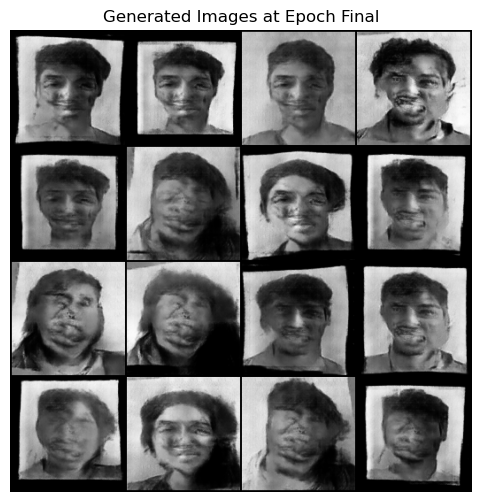

In [13]:
generator.eval()
with torch.no_grad():
    sample_noise = torch.randn(16, latent_dim, 1, 1, device=device)
    generated_images = generator(sample_noise)
    show_generated_images(generated_images, epoch="Final")

In [14]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import os

# ======= Corrected Generator Class (bias=False) =======
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),   # 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),          # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),           # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),           # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, channels, 4, 4, 0, bias=False),      # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


# ======= Load Trained Generator =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100, channels=1).to(device)

checkpoint_path = "dcgan_generator_faces.pth"
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
generator.eval()  # Set to evaluation mode

print("✅ Generator loaded successfully!")

# ======= Generate 100 Random Faces =======
num_samples = 100
latent_dim = 100

# Generate random noise
z = torch.randn(num_samples, latent_dim, 1, 1, device=device)

# Generate fake images
with torch.no_grad():
    fake_images = generator(z)

# Denormalize [-1,1] → [0,1]
fake_images = (fake_images + 1) / 2

# ======= Save all generated images =======
output_dir = "generated_faces"
os.makedirs(output_dir, exist_ok=True)

for i in range(num_samples):
    img = fake_images[i].cpu()
    torchvision.utils.save_image(img, f"{output_dir}/face_{i+1:03d}.png")

print(f"✅ Saved {num_samples} generated faces in '{output_dir}' folder.")

# ======= (Optional) Display first 16 images =======
grid = torchvision.utils.make_grid(fake_images[:16], nrow=4, padding=2)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title("Sample Generated Faces")
plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(), cmap='gray')
plt.show()


RuntimeError: Error(s) in loading state_dict for Generator:
	Unexpected key(s) in state_dict: "net.0.bias", "net.3.bias", "net.6.bias", "net.9.bias", "net.12.bias". 
	size mismatch for net.0.weight: copying a param with shape torch.Size([100, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([100, 1024, 4, 4]).
	size mismatch for net.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for net.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for net.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for net.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for net.3.weight: copying a param with shape torch.Size([512, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([1024, 512, 4, 4]).
	size mismatch for net.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for net.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for net.4.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for net.4.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for net.6.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 4, 4]).
	size mismatch for net.7.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.7.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.7.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.7.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.9.weight: copying a param with shape torch.Size([128, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4, 4]).
	size mismatch for net.10.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for net.10.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for net.10.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for net.10.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for net.12.weight: copying a param with shape torch.Size([64, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 1, 4, 4]).